In [12]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python


Cloning into 'Facial-Expression-Dataset'...
remote: Enumerating objects: 34052, done.
remote: Counting objects: 100% (34052/34052), done.
remote: Compressing objects: 100% (34048/34048), done.
remote: Total 34052 (delta 4), reused 34052 (delta 4), pack-reused 0
Receiving objects: 100% (34052/34052), 52.31 MiB | 23.79 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (35887/35887), done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-fqn_fr7t
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-fqn_fr7t
     |████████████████████████████████| 47.8 MB 2.3 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=9395a76e4779f47153621e705b6198846e7f9ffaacc546ba00fbbc374c28212b
  Stored in directory: /tmp/pip-ephem-wheel-cache-3rlwdtgd/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albument

In [13]:
import numpy as np 
import matplotlib.pyplot as plt
import torch

In [14]:
TRAIN_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/train/'
VALID_IMG_FOLDER_PATH = '/content/Facial-Expression-Dataset/validation/'

In [15]:
LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15
DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'

In [16]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

train_augs = T.Compose([
        T.RandomHorizontalFlip(p = 0.5),
        T.RandomRotation(degrees=(-20, +20)),
        T.ToTensor()
])


In [17]:
valid_augs = T.Compose([
        T.ToTensor()
])

In [18]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform= valid_augs)

In [19]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")


Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [20]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


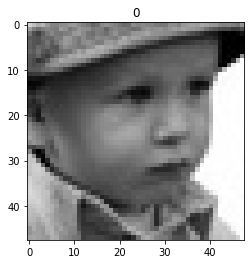

In [21]:
image, label = trainset[20]
plt.imshow (image. permute(1,2,0))
plt.title(label);
#represent as 0, angry

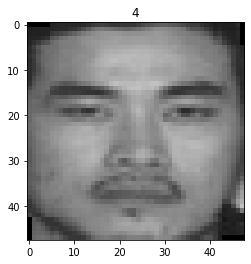

In [22]:
image, label = trainset[18888]
plt.imshow (image. permute(1,2,0))
plt.title(label);
#represent as 4, sad

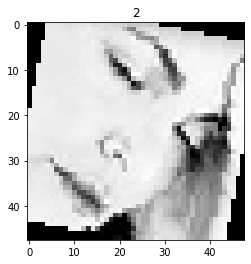

In [23]:
image, label = trainset[5000]
plt.imshow (image. permute(1,2,0))
plt.title(label);
#represent as 2, fear

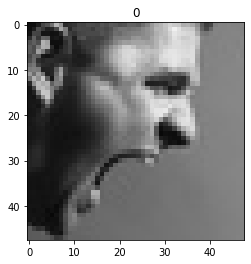

In [24]:
image, label = validset[888]
plt.imshow (image. permute(1,2,0))
plt.title(label);
#also works for the valid set, represent as 0, angry

In [25]:
from torch.utils.data import DataLoader

In [26]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [27]:
for images, labels in trainloader:
    break;


In [28]:
print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


In [29]:
import timm 
from torch import nn
class FaceModel(nn.Module):
  def __init__(self):
    super(FaceModel,self).__init__()

    self.eff_net = timm.create_model('efficientnet_b0', pretrained = True, num_classes = 7)
  def forward(self, images, labels = None):
    logits = self.eff_net(images)

    if labels != None:
        loss = nn.CrossEntropyLoss()(logits, labels)
        return logits, loss
    return logits


In [43]:
model = FaceModel()

In [45]:
from tqdm.notebook import tqdm
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [46]:
def train_fn(model, dataloader, optimizer, current_epo):

  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH"+"[TRAIN]"+str(current_epo + 1) +"/"+str(EPOCHS))

  for t, data in enumerate(tk):
    images,labels = data
    images,labels = image.to(DEVICE), labels.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss':'%6f'%float(total_loss/(t+1)), 'acc':'%6f'%float(total_acc / (t+1)),})

  return total_loss / len(dataloader), total_acc/len(dataloader)


In [47]:
def eval_fn(model, dataloader, current_epo):

  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "EPOCH"+"[VALID]"+str(current_epo + 1) +"/"+str(EPOCHS))

  for t, data in enumerate(tk):
    images,labels = data
    images,labels = image.to(DEVICE), labels.to(DEVICE)

   
    logits, loss = model(images, labels)
    
    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss':'%6f'%float(total_loss/(t+1)), 'acc':'%6f'%float(total_acc / (t+1)),})

  return total_loss / len(dataloader), total_acc/len(dataloader)
  


In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [48]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  avg_train_loss = train_fn(model, trainloader, optimizer, i)
  avg_valid_loss = eval_fn(model, validloader, i)
  
  if avg_valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best-weights.pt')
    print("SAVED-BEST-WEIGHTS")
    best_valid_loss = valid_loss
  print("Epoch:{} Train_loss : {}".format(i+1,avg_train_loss))
  print("Epoch:{} Valid_loss : {}".format(i+1,avg_valid_loss))

EPOCH[TRAIN]1/15:   0%|          | 0/901 [00:00<?, ?it/s]

RuntimeError: ignored

In [2]:
def view_classify(img, ps):
  classes = ['angry','disgust','fear','neutral','sad', 'surprise']
  ps = ps.data.cpu().numpy().squeeze()
  img = img.numpy().transpose(1,2,0)

  fig,(ax1,ax2) = plt.subplots(figsize = (5,9), ncols=2)
  ax1.imshow(img)
  ax1.axis('off')
  ax2.barh(classes,ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(classes)
  ax2.set_yticklabels(classes)
  ax2.set_title('Class Probability')
  ax2.set_xlim(0,1.1)

  plt.tight_layout()

  return None